In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Saliency computation

We will calculate the saliency for the `lena` image using the independent components gathered earlier.

In [334]:
from PIL import Image

img = Image.open("./CAT2000_train/Stimuli/Random/007.jpg")
smap = Image.open("./CAT2000_train/FIXATIONMAPS/Random/005.jpg")

img.thumbnail((512, 512))
smap.thumbnail((512, 512))

img = np.array(img)/255
smap = np.array(smap)/255

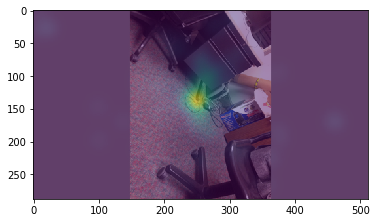

In [335]:
plt.imshow(img)
plt.imshow(smap, alpha=0.5)

plt.show()

In [336]:
def extract_patches(img, size=11):
    n, m, c = img.shape
    n = n - size + 1
    m = m - size + 1

    dimensions = size**2 * c
    patches = np.zeros((dimensions, n*m))
    
    for i in range(n*m):
        col = i  % m
        row = i // m
        patches[:, i] = np.reshape(img[row:row+size, col:col+size, :], dimensions, "F")

    return patches

In [337]:
patches = extract_patches(img)

Now compute the saliency using our data and the original SUN data and compare the saliency maps.

In [338]:
def compute_saliency(patches, filters, dimensions, sigma=None, theta=None):
    n_filters, filter_size = filters.shape
    size = int(np.sqrt(filter_size/3))
    
    if sigma is None:
        sigma = np.ones((n_filters))
        
    if theta is None:
        theta = np.ones((n_filters))
    
    n, m, _ = dimensions
    n = n - size + 1
    m = m - size + 1

    dimensions = (n, m)
    
    activation = filters @ patches
    saliency_map = sum([(np.abs(activation[i].T)/sigma[i])**theta[i] for i in range(n_filters)])
    
    return saliency_map.reshape(dimensions)

In [339]:
from scipy.io import loadmat

# Load data from original SUN paper
mat = loadmat("/Users/jesperwohlerthansen/Downloads/saliency/stats.mat")

filters = mat["B1"]
sigma = mat["sigmas"].reshape(-1)
theta = mat["thetas"].reshape(-1)

In [340]:
# Custom independent components
ica_components = np.load("ica.npz.npy")
ica_components -= np.mean(ica_components, 0)

In [341]:
saliency_sun = compute_saliency(patches, filters, img.shape, sigma=sigma, theta=theta)
saliency = compute_saliency(patches, filters, img.shape)

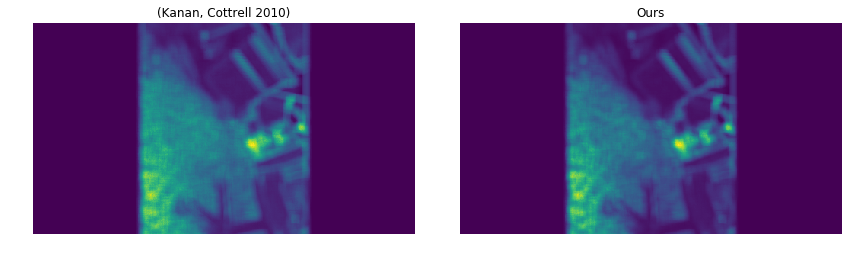

In [342]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

ax1.imshow(saliency_sun)
ax1.set_title("(Kanan, Cottrell 2010)")
ax1.axis("off")

ax2.imshow(saliency)
ax2.set_title("Ours")
ax2.axis("off")

plt.tight_layout()

plt.show()